In [1]:
import pandas as pd
import numpy as np

clients = pd.read_csv("C:/Users/U_M1P8G/Desktop/IDE/Доп. главы высшей математики/Кластеризация и техники понижения размерности/data/CC GENERAL.csv")

In [2]:
clients.head(3)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.0,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12


In [6]:
clients.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [8]:
columns_with_na = ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']

# Заполняем все указанные столбцы их средними значениями
clients[columns_with_na] = clients[columns_with_na].apply(lambda x: x.fillna(x.mean()))


In [9]:
clients['MINIMUM_PAYMENTS'].mean()

np.float64(864.2065423050827)

In [10]:
clients.drop(columns=['CUST_ID'], inplace = True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clients_scaled = scaler.fit_transform(clients)

clients_scaled[0][0]

np.float64(-0.7319893664465486)

Применим метод k-means
1. Найдем оптимальное кол-во кластеров с помощью к-та силуэта

k = 2: Silhouette Score = 0.209
k = 3: Silhouette Score = 0.251
k = 4: Silhouette Score = 0.198
k = 5: Silhouette Score = 0.193
k = 6: Silhouette Score = 0.203
k = 7: Silhouette Score = 0.215
k = 8: Silhouette Score = 0.213
k = 9: Silhouette Score = 0.215


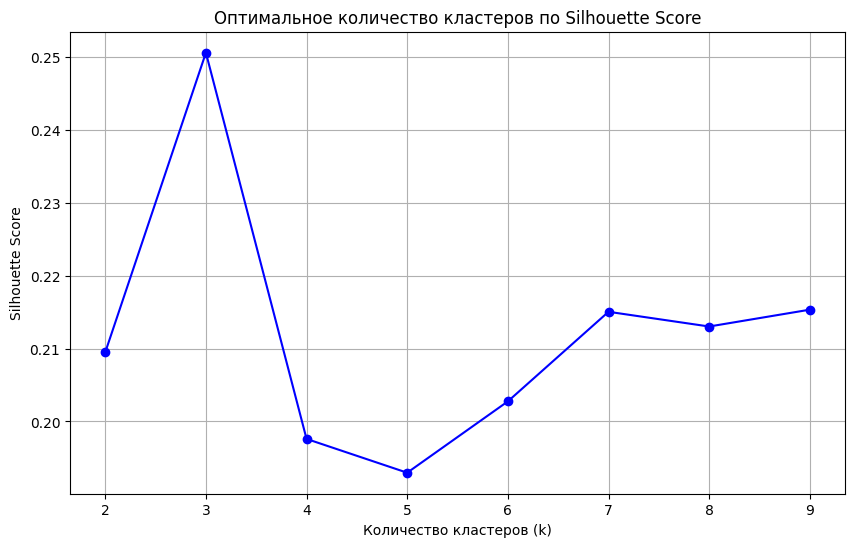

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init = 'random')
    labels = kmeans.fit_predict(clients_scaled)
    score = silhouette_score(clients_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k}: Silhouette Score = {score:.3f}")
    
    
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Оптимальное количество кластеров по Silhouette Score')
plt.grid(True)
plt.show()

Реализуем кластеризацию k-means

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, init = 'random')
kmeans.fit(clients_scaled)

labels = kmeans.labels_

unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("\nВ виде словаря:", cluster_counts)


В виде словаря: {np.int32(0): np.int64(1235), np.int32(1): np.int64(1596), np.int32(2): np.int64(6119)}


Реализуем dbscan с параметрами по умолчанию

In [19]:
from sklearn.cluster import DBSCAN
model = DBSCAN()
model.fit(clients_scaled)
labels = model.fit_predict(clients_scaled) 
unique_labels = np.unique(labels)
print(f"Метки кластеров: {unique_labels}")

Метки кластеров: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


В предыдущем задании получилось очень много кластеров. Возможно, это случилось потому, что мы взяли параметры по умолчанию, а результат алгоритма DBSCAN, как вы помните, очень чувствителен к ним.

Давайте попробуем с помощью цикла перебрать параметр eps по значениям, заданным как np.arange(0.1,3,0.2), а параметр min_samples — по значениям, заданным как range(1,20,4). Найдите комбинацию, которая даёт максимальное значение коэффициента силуэта.

In [22]:
silhouette_scores = []
eps_range = np.arange(0.1,3,0.2)
min_samples_range = range(1,20,4)

for i in eps_range:
    for j in min_samples_range:
        model = DBSCAN(eps = i, min_samples=j)
        labels = model.fit_predict(clients_scaled)
        model.fit(clients_scaled)
        labels = model.fit_predict(clients_scaled) 
        
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        
        score = silhouette_score(clients_scaled, labels)
        silhouette_scores.append((i, j, score, n_clusters))
        print(f"eps = {i:.1f}, min_samples = {j}: Score = {score:.3f}, Clusters = {n_clusters}")

eps = 0.1, min_samples = 1: Score = 0.016, Clusters = 8672
eps = 0.1, min_samples = 5: Score = -0.375, Clusters = 11
eps = 0.1, min_samples = 9: Score = -0.254, Clusters = 2
eps = 0.1, min_samples = 13: Score = -0.244, Clusters = 1
eps = 0.1, min_samples = 17: Score = -0.250, Clusters = 2
eps = 0.3, min_samples = 1: Score = 0.023, Clusters = 7647
eps = 0.3, min_samples = 5: Score = -0.424, Clusters = 41
eps = 0.3, min_samples = 9: Score = -0.404, Clusters = 14
eps = 0.3, min_samples = 13: Score = -0.352, Clusters = 8
eps = 0.3, min_samples = 17: Score = -0.353, Clusters = 6
eps = 0.5, min_samples = 1: Score = -0.145, Clusters = 5995
eps = 0.5, min_samples = 5: Score = -0.444, Clusters = 38
eps = 0.5, min_samples = 9: Score = -0.318, Clusters = 10
eps = 0.5, min_samples = 13: Score = -0.134, Clusters = 3
eps = 0.5, min_samples = 17: Score = -0.186, Clusters = 4
eps = 0.7, min_samples = 1: Score = -0.261, Clusters = 4509
eps = 0.7, min_samples = 5: Score = -0.439, Clusters = 28
eps = 0.7

In [23]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame(silhouette_scores, columns=['eps', 'min_samples', 'score', 'n_clusters'])

# Находим оптимальные параметры
best_result = results_df[results_df['score'] > 0].loc[results_df['score'].idxmax()]
print(f"\nОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:")
print(f"eps = {best_result['eps']:.1f}, min_samples = {best_result['min_samples']}")
print(f"Silhouette Score = {best_result['score']:.3f}")
print(f"Количество кластеров = {best_result['n_clusters']}")


ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
eps = 2.9, min_samples = 5.0
Silhouette Score = 0.617
Количество кластеров = 1.0


Теперь давайте реализуем агломеративную иерархическую кластеризацию. Переберите количество кластеров в диапазоне от 3 до 9 включительно и найдите то их число, которое будет давать максимальный коэффициент силуэта.

In [25]:
from sklearn.cluster import AgglomerativeClustering

for i in range (3,10):
    model = AgglomerativeClustering(n_clusters=i)
    model.fit(clients_scaled)
    labels = model.fit_predict(clients_scaled) 
                
    score = silhouette_score(clients_scaled, labels)
    silhouette_scores.append((i, score, n_clusters))
    print(f"Score = {score:.3f}, Clusters = {i}")

Score = 0.173, Clusters = 3
Score = 0.155, Clusters = 4
Score = 0.158, Clusters = 5
Score = 0.173, Clusters = 6
Score = 0.156, Clusters = 7
Score = 0.152, Clusters = 8
Score = 0.154, Clusters = 9


In [27]:
model = AgglomerativeClustering(n_clusters=6)
model.fit(clients_scaled)
labels = model.fit_predict(clients_scaled) 

clients = pd.DataFrame(clients, columns=clients.columns)  # используем исходные названия столбцов
clients['cluster'] = labels
clients['cluster'].value_counts()

cluster
0    3946
1    2931
2     864
5     722
3     464
4      23
Name: count, dtype: int64